# Check angle boxplot DURING last scan

In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
from pp_utils.core import generate_data_path_dict, MISC_PARAMS
from pp_utils.file_handling import df_main_loader
# from pp_utils.trial_processor import TrialProcessor
from pp_utils import utils
import pp_utils.inspection_angle as ia

In [3]:
import pickle

## Set paths, load main info df and clusters

In [4]:
data_path = generate_data_path_dict(Path("../data_processed/"))
raw_path = Path("../data_raw/")

### Data and output path

In [5]:
output_path = data_path["main"] / "data_summary"
tp_path = output_path / "trial_processor_object"

In [6]:
fig_path = Path("../figs")
if not fig_path.exists():
    fig_path.mkdir()

### Load main dataframe

In [7]:
df_main = df_main_loader(
    folder=data_path["info_csv"], filename="main_info_append_09.csv",
)

### Load clustering results

In [8]:
with open(output_path / "clustering_7_rostrum_only.pickle", "rb") as filein:
    cluster_fnameprefix_7 = pickle.load(filein)

### Load compiled trial info and track portion

In [9]:
df_summary = pd.read_csv(output_path / "data_summary_all.csv", index_col=0)

In [10]:
with open(output_path / "track_portion_all.pickle", "rb") as filein:
    df_track_portion_all = pickle.load(filein)

## Sort clusters

### 7clusters

In [11]:
# Clean up clusters
# 0: TC-straight, 1: TC-very curved, 2: TC-curved (need to change sequence to: 0-2-1)
# 3: CT-very curved, 4: CT-curved, 6: CT-straight (need to change sequence to: 6-4-3)
df_cluster_7 = []
for seq, fp_list in enumerate(cluster_fnameprefix_7):
    df_sel = utils.sort_df_in_cluster(fp_list, df_summary)
    df_cluster_7.append(df_sel)

In [12]:
# Change sequence
new_seq = [0, 2, 1, 6, 4, 3]
df_cluster_clean_7 = []
for seq in new_seq:
    df_cluster_clean_7.append(df_cluster_7[seq])

In [13]:
# Sanity check that we've swapped things correctly
print([len(df) for df in df_cluster_7])
print([len(df) for df in df_cluster_clean_7])

[16, 9, 16, 6, 8, 1, 23]
[16, 16, 9, 23, 8, 6]


In [14]:
CLUSTER_STR_7 = [
    "R+/Straight", "R+/Curved-1", "R+/Curved-2",
    "L+/Straight", "L+/Curved-1", "L+/Curved-2"
]

In [31]:
# Scenarios
SCENARIO_STR = [
    "TC1", "TC2", "TC3", "TC4",
    "CT1", "CT2", "CT3", "CT4",
]

## Gather data for the last scan

In [15]:
# Click RL threshold
MISC_PARAMS["th_RL"]

140

### Functions

In [16]:
def get_clicks(trial_idx):
    # Load TrialProcessor object
    tp_obj_fname = tp_path / f"trial_{trial_idx:03d}.pickle"
    with open(tp_obj_fname, "rb") as filein:
        tp = pickle.load(filein)
    
    # Filter out only clicks during the last scan
    df_ch0 = utils.filter_clicks_during_last_scan(
        df_h=tp.df_hydro_ch0.copy(),
        th_RL=MISC_PARAMS["th_RL"],
        time_last_scan_start=tp.last_scan_start,
        time_last_scan_end=tp.last_scan_end
    )
    df_ch1 = utils.filter_clicks_during_last_scan(
        df_h=tp.df_hydro_ch1.copy(),
        th_RL=MISC_PARAMS["th_RL"],
        time_last_scan_start=tp.last_scan_start,
        time_last_scan_end=tp.last_scan_end
    )

    # Print if decision made before reaching range threshold
    if tp.last_scan_end < tp.last_scan_start:
        print(f"Trial {trial_idx}: last scan start/end time invalid!")

    # Check if any df is empty
    if isinstance(df_ch0, pd.DataFrame) and len(df_ch0) == 0:
        print(f"Trial {trial_idx}: df_ch0 is empty")
    if isinstance(df_ch1, pd.DataFrame) and len(df_ch1) == 0:
        print(f"Trial {trial_idx}: df_ch1 is empty")
    
    return df_ch0, df_ch1

In [17]:
def get_trial_angle_dist(
    trial_idx, col_name="enso_angle", **kwargs
):
    """
    kwargs include:
        - enso_bin
        - time_binning
        - count_type
        - bin_delta
        - density
    
    Use col_name="enso_angle_flip" to flip enso_angle first before binning
    """
    df_ch0, df_ch1 = get_clicks(trial_idx)

    # Create a column for flipped angle if specified
    if col_name == "enso_angle_flip":
        df_ch0["enso_angle_flip"] = ia.enso2spheroid_angle(df_ch0["enso_angle"])
        df_ch1["enso_angle_flip"] = ia.enso2spheroid_angle(df_ch1["enso_angle"])
    
    # Get angle span
    ch0_angle_span = df_ch0["enso_angle"].max() - df_ch0["enso_angle"].min()
    ch1_angle_span = df_ch1["enso_angle"].max() - df_ch1["enso_angle"].min()

    # Get distribution
    ch0_dist = ia.get_angle_dist(df_click=df_ch0, col_name=col_name, **kwargs)
    ch1_dist = ia.get_angle_dist(df_click=df_ch1, col_name=col_name, **kwargs)
    
    return ch0_dist, ch1_dist, ch0_angle_span, ch1_angle_span

### Set up histgram params

In [18]:
enso_bin = np.arange(-90, 95, 3.75)
x_hist = (enso_bin[:-1] + enso_bin[1:])/2

In [19]:
enso_bin_size = enso_bin[1] - enso_bin[0]

In [20]:
binning_params = {
    "angle_bin": enso_bin,
    "time_binning": False,
    "density": False,
}

In [21]:
plot_params_ch0 = {
    "alpha": 0.5,
    "edgecolor": "k",
    "facecolor": "C0",
    "linewidth": 1
}
plot_params_ch1 = plot_params_ch0.copy()
plot_params_ch1["facecolor"] = "C1"

## Find a way to check the majority of clicks in buzz cases

### Trial 182

In [22]:
# if trials exist under this scenario
trial_idx = 182
print(f"----- Trial index={trial_idx} ----------")
ch0_dist, ch1_dist, ch0_angle_span, ch1_angle_span = get_trial_angle_dist(
    trial_idx,
    col_name="enso_angle_flip",
    **binning_params,
)
print(f"Ch1 angle span={ch1_angle_span:3.3f} deg")

----- Trial index=182 ----------


Trial 182: df_ch0 is empty
Ch1 angle span=42.500 deg


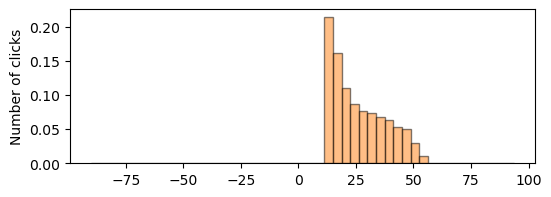

In [23]:
plt.figure(figsize=(6,2))
plt.bar(x=x_hist, width=enso_bin_size, height=ch1_dist/ch1_dist.sum(), **plot_params_ch1)
plt.ylabel("Number of clicks")
plt.show()

In [24]:
_, df_ch1 = get_clicks(trial_idx)
df_ch1["enso_angle_flip"] = ia.enso2spheroid_angle(df_ch1["enso_angle"])

Trial 182: df_ch0 is empty


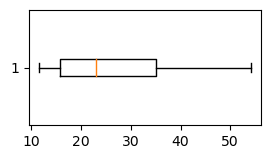

In [25]:
plt.figure(figsize=(3,1.5))
plt.boxplot(df_ch1["enso_angle_flip"], vert=False)
plt.show()

### Trial 218

In [26]:
# if trials exist under this scenario
trial_idx = 218
print(f"----- Trial index={trial_idx} ----------")
ch0_dist, ch1_dist, ch0_angle_span, ch1_angle_span = get_trial_angle_dist(
    trial_idx,
    col_name="enso_angle_flip",
    **binning_params,
)
print(f"Ch1 angle span={ch1_angle_span:3.3f} deg")

----- Trial index=218 ----------
Trial 218: df_ch0 is empty
Ch1 angle span=15.282 deg


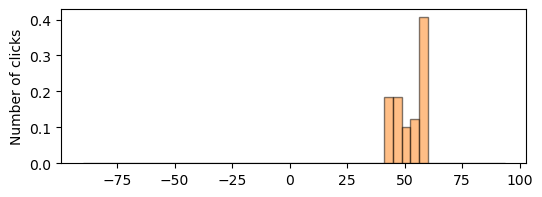

In [27]:
plt.figure(figsize=(6,2))
plt.bar(x=x_hist, width=enso_bin_size, height=ch1_dist/ch1_dist.sum(), **plot_params_ch1)
plt.ylabel("Number of clicks")
plt.show()

In [28]:
_, df_ch1 = get_clicks(trial_idx)
df_ch1["enso_angle_flip"] = ia.enso2spheroid_angle(df_ch1["enso_angle"])

Trial 218: df_ch0 is empty


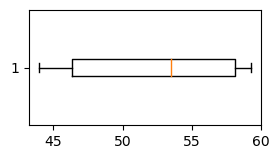

In [29]:
plt.figure(figsize=(3,1.5))
plt.boxplot(df_ch1["enso_angle_flip"], vert=False)
plt.show()

### Boxplot for 1 cluster

R+/Straight

----- Trial index=242 ----------
Trial 242: df_ch0 is empty
Ch1 angle span=15.282 deg

----- Trial index=223 ----------
Trial 223: df_ch0 is empty
Ch1 angle span=15.282 deg

----- Trial index=238 ----------
Ch1 angle span=15.282 deg

----- Trial index=96 ----------
Ch1 angle span=15.282 deg

----- Trial index=97 ----------
Ch1 angle span=15.282 deg

----- Trial index=236 ----------
Trial 236: df_ch0 is empty
Ch1 angle span=15.282 deg

----- Trial index=134 ----------
Trial 134: df_ch0 is empty
Ch1 angle span=15.282 deg

----- Trial index=215 ----------
Trial 215: df_ch0 is empty
Ch1 angle span=15.282 deg

----- Trial index=132 ----------
Trial 132: df_ch0 is empty
Ch1 angle span=15.282 deg

----- Trial index=112 ----------
Trial 112: df_ch0 is empty
Ch1 angle span=15.282 deg

----- Trial index=178 ----------
Ch1 angle span=15.282 deg

----- Trial index=89 ----------
Trial 89: df_ch0 is empty
Ch1 angle span=15.282 deg

----- Trial index=191 ----------
Ch1 angle span=15.282 

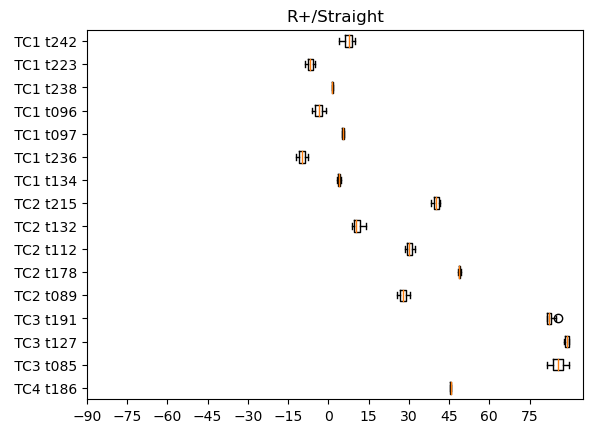

R+/Curved-1

----- Trial index=114 ----------
Trial 114: df_ch0 is empty
Ch1 angle span=15.282 deg

----- Trial index=80 ----------
Trial 80: df_ch0 is empty
Ch1 angle span=15.282 deg

----- Trial index=155 ----------
Trial 155: df_ch0 is empty
Ch1 angle span=15.282 deg

----- Trial index=216 ----------
Trial 216: df_ch0 is empty
Ch1 angle span=15.282 deg

----- Trial index=221 ----------
Trial 221: df_ch0 is empty
Ch1 angle span=15.282 deg

----- Trial index=135 ----------
Trial 135: df_ch0 is empty
Ch1 angle span=15.282 deg

----- Trial index=138 ----------
Ch1 angle span=15.282 deg

----- Trial index=179 ----------
Ch1 angle span=15.282 deg

----- Trial index=189 ----------
Trial 189: df_ch0 is empty
Ch1 angle span=15.282 deg

----- Trial index=183 ----------
Trial 183: df_ch0 is empty
Ch1 angle span=15.282 deg

----- Trial index=125 ----------
Trial 125: df_ch0 is empty
Ch1 angle span=15.282 deg

----- Trial index=139 ----------
Ch1 angle span=15.282 deg

----- Trial index=123 ----

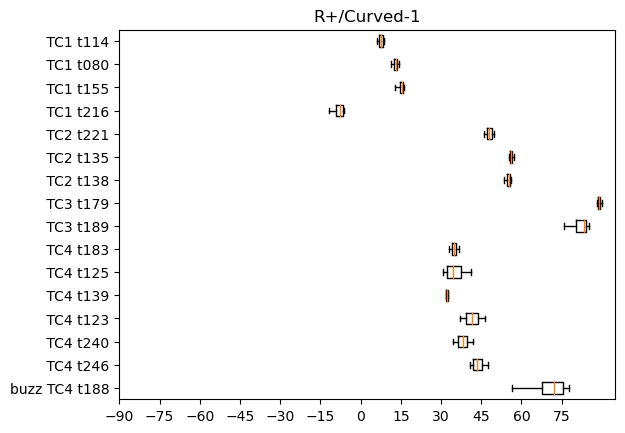

R+/Curved-2

----- Trial index=78 ----------
Trial 78: df_ch0 is empty
Ch1 angle span=15.282 deg
Buzz initiated during last scan!

----- Trial index=92 ----------
Ch1 angle span=15.282 deg
Buzz initiated during last scan!

----- Trial index=159 ----------
Ch1 angle span=15.282 deg

----- Trial index=129 ----------
Trial 129: df_ch0 is empty
Ch1 angle span=15.282 deg
Buzz initiated during last scan!

----- Trial index=218 ----------
Trial 218: df_ch0 is empty
Ch1 angle span=15.282 deg

----- Trial index=176 ----------
Trial 176: df_ch0 is empty
Ch1 angle span=15.282 deg

----- Trial index=161 ----------
Trial 161: df_ch0 is empty
Ch1 angle span=15.282 deg
Buzz initiated during last scan!

----- Trial index=212 ----------
Trial 212: df_ch0 is empty
Ch1 angle span=15.282 deg

----- Trial index=239 ----------
Trial 239: df_ch0 is empty
Ch1 angle span=15.282 deg
Buzz initiated during last scan!


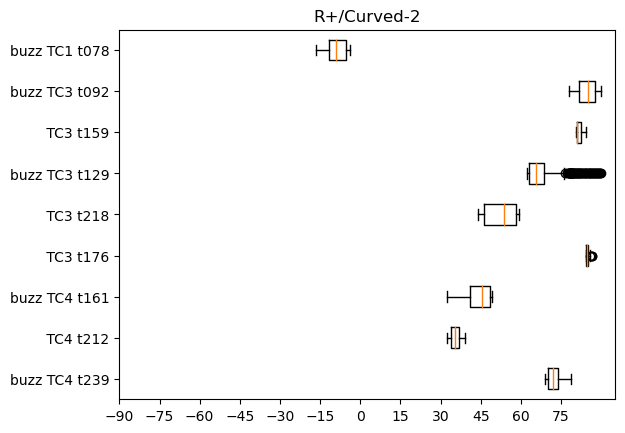

L+/Straight

----- Trial index=131 ----------
Ch1 angle span=15.282 deg

----- Trial index=84 ----------
Trial 84: df_ch0 is empty
Ch1 angle span=15.282 deg

----- Trial index=184 ----------
Trial 184: df_ch0 is empty
Ch1 angle span=15.282 deg

----- Trial index=111 ----------
Trial 111: df_ch0 is empty
Ch1 angle span=15.282 deg

----- Trial index=86 ----------
Trial 86: df_ch0 is empty
Ch1 angle span=15.282 deg

----- Trial index=237 ----------
Trial 237: df_ch0 is empty
Ch1 angle span=15.282 deg

----- Trial index=187 ----------
Ch1 angle span=15.282 deg

----- Trial index=91 ----------
Trial 91: df_ch0 is empty
Ch1 angle span=15.282 deg

----- Trial index=241 ----------
Trial 241: df_ch0 is empty
Ch1 angle span=15.282 deg

----- Trial index=243 ----------
Trial 243: df_ch0 is empty
Ch1 angle span=15.282 deg

----- Trial index=154 ----------
Trial 154: df_ch0 is empty
Ch1 angle span=15.282 deg

----- Trial index=160 ----------
Ch1 angle span=15.282 deg

----- Trial index=133 --------

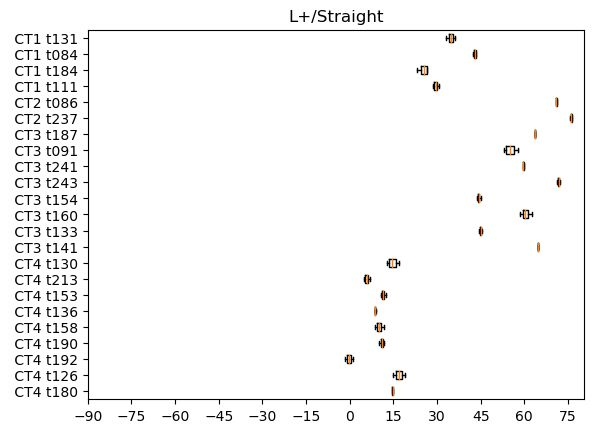

L+/Curved-1

----- Trial index=90 ----------
Trial 90: df_ch0 is empty
Ch1 angle span=15.282 deg

----- Trial index=219 ----------
Trial 219: df_ch0 is empty
Ch1 angle span=15.282 deg
Buzz initiated during last scan!

----- Trial index=207 ----------
Trial 207: df_ch0 is empty
Ch1 angle span=15.282 deg

----- Trial index=235 ----------
Trial 235: df_ch0 is empty
Ch1 angle span=15.282 deg

----- Trial index=79 ----------
Trial 79: df_ch0 is empty
Ch1 angle span=15.282 deg

----- Trial index=220 ----------
Trial 220: df_ch0 is empty
Ch1 angle span=15.282 deg

----- Trial index=181 ----------
Trial 181: df_ch0 is empty
Ch1 angle span=15.282 deg

----- Trial index=222 ----------
Trial 222: df_ch0 is empty
Ch1 angle span=15.282 deg


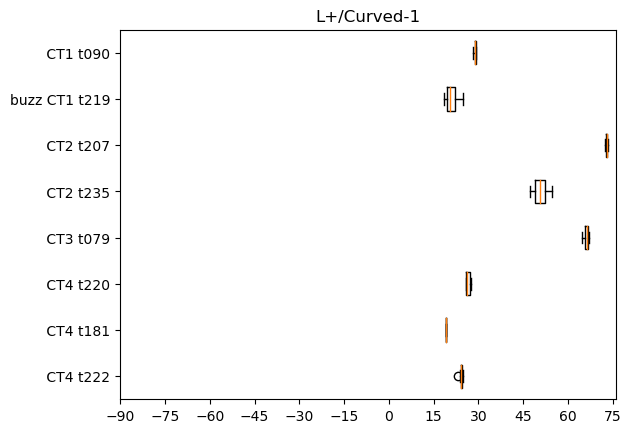

L+/Curved-2

----- Trial index=82 ----------
Trial 82: df_ch0 is empty
Ch1 angle span=15.282 deg

----- Trial index=217 ----------
Trial 217: df_ch0 is empty
Ch1 angle span=15.282 deg

----- Trial index=117 ----------
Trial 117: df_ch0 is empty
Ch1 angle span=15.282 deg

----- Trial index=182 ----------
Trial 182: df_ch0 is empty
Ch1 angle span=15.282 deg
Buzz initiated during last scan!

----- Trial index=121 ----------
Trial 121: df_ch0 is empty
Ch1 angle span=15.282 deg

----- Trial index=205 ----------
Trial 205: df_ch0 is empty
Ch1 angle span=15.282 deg


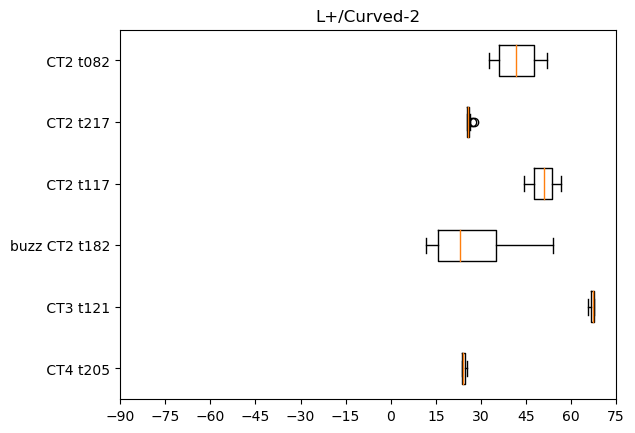

In [37]:
for cluster_idx in range(6):
    df_cluster = df_cluster_clean_7[cluster_idx]
    print(CLUSTER_STR_7[cluster_idx])

    str_all = []
    click_ch1_all = []
    buzz_str = ""
    for tca in SCENARIO_STR:
        df_tca = df_cluster[df_cluster["TARGET_ANGLE"] == tca]
        if len(df_tca) == 0:
            continue

        # if trials exist under this scenario
        for trial_idx in df_tca.index:
            print("")
            print(f"----- Trial index={trial_idx} ----------")

            _, df_ch1 = get_clicks(trial_idx)
            df_ch1["enso_angle_flip"] = ia.enso2spheroid_angle(df_ch1["enso_angle"])

            print(f"Ch1 angle span={ch1_angle_span:3.3f} deg")

            # If buzz initiated during last scan
            if df_summary.loc[trial_idx]["time_buzz_onset_clean"] < df_summary.loc[trial_idx]["time_decision"]:
                print("Buzz initiated during last scan!")
                buzz_str = "buzz"
            else:
                buzz_str = ""

            str_trial = f"{buzz_str} {tca} t{trial_idx:03d}"
            click_ch1_all.append(df_ch1["enso_angle_flip"])
            str_all.append(str_trial)

    plt.boxplot(click_ch1_all, vert=False)
    plt.yticks(np.arange(len(str_all))+1, str_all)
    plt.xticks(np.arange(-90, 90, 15))
    plt.title(CLUSTER_STR_7[cluster_idx])
    plt.gca().invert_yaxis()
    plt.show()

R+/Straight

----- Trial index=242 ----------
Trial 242: df_ch0 is empty
Ch1 angle span=15.282 deg

----- Trial index=223 ----------
Trial 223: df_ch0 is empty
Ch1 angle span=15.282 deg

----- Trial index=238 ----------
Ch1 angle span=15.282 deg

----- Trial index=96 ----------
Ch1 angle span=15.282 deg

----- Trial index=97 ----------
Ch1 angle span=15.282 deg

----- Trial index=236 ----------
Trial 236: df_ch0 is empty
Ch1 angle span=15.282 deg

----- Trial index=134 ----------
Trial 134: df_ch0 is empty
Ch1 angle span=15.282 deg

----- Trial index=215 ----------
Trial 215: df_ch0 is empty
Ch1 angle span=15.282 deg

----- Trial index=132 ----------
Trial 132: df_ch0 is empty
Ch1 angle span=15.282 deg

----- Trial index=112 ----------
Trial 112: df_ch0 is empty
Ch1 angle span=15.282 deg

----- Trial index=178 ----------
Ch1 angle span=15.282 deg

----- Trial index=89 ----------
Trial 89: df_ch0 is empty
Ch1 angle span=15.282 deg

----- Trial index=191 ----------
Ch1 angle span=15.282 

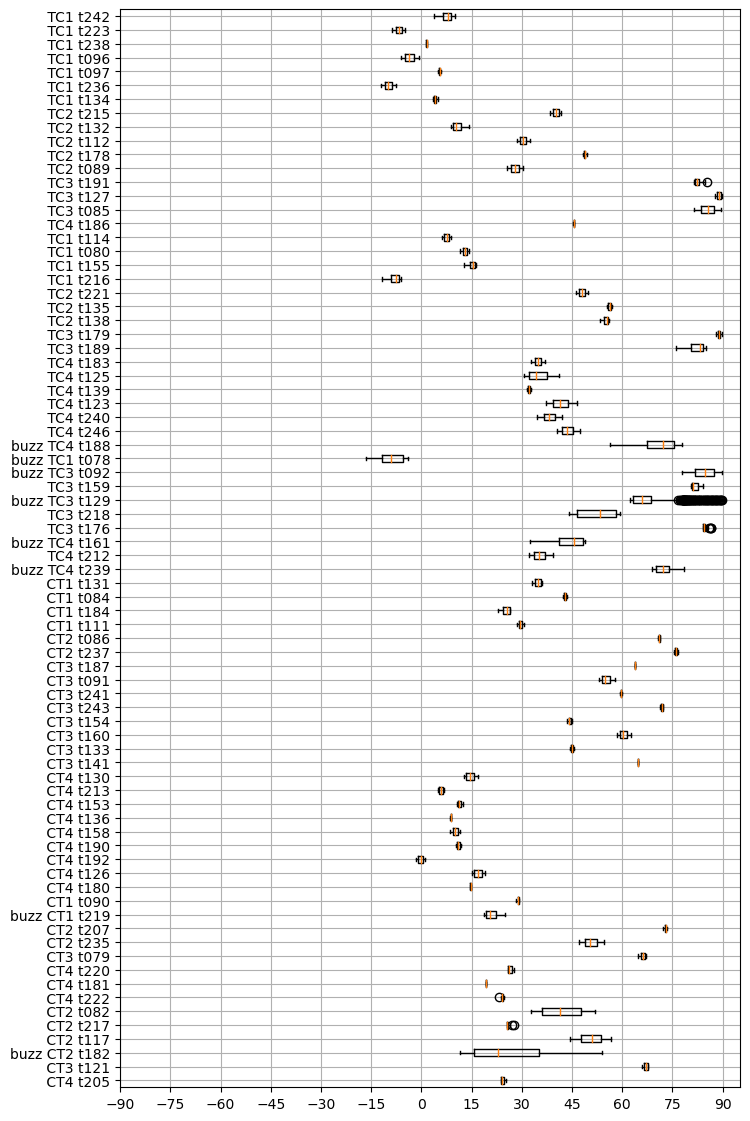

In [48]:
str_all = []
click_ch1_all = []
buzz_str = ""
cluster_cut = []

for cluster_idx in range(6):
    df_cluster = df_cluster_clean_7[cluster_idx]
    print(CLUSTER_STR_7[cluster_idx])

    cluster_cut.append(len(df_cluster))

    for tca in SCENARIO_STR:
        df_tca = df_cluster[df_cluster["TARGET_ANGLE"] == tca]
        if len(df_tca) == 0:
            continue

        # if trials exist under this scenario
        for trial_idx in df_tca.index:
            print("")
            print(f"----- Trial index={trial_idx} ----------")

            _, df_ch1 = get_clicks(trial_idx)
            df_ch1["enso_angle_flip"] = ia.enso2spheroid_angle(df_ch1["enso_angle"])

            print(f"Ch1 angle span={ch1_angle_span:3.3f} deg")

            # If buzz initiated during last scan
            if df_summary.loc[trial_idx]["time_buzz_onset_clean"] < df_summary.loc[trial_idx]["time_decision"]:
                print("Buzz initiated during last scan!")
                buzz_str = "buzz"
            else:
                buzz_str = ""

            str_trial = f"{buzz_str} {tca} t{trial_idx:03d}"
            click_ch1_all.append(df_ch1["enso_angle_flip"])
            str_all.append(str_trial)

plt.figure(figsize=(8,14))
plt.boxplot(click_ch1_all, vert=False)
plt.yticks(np.arange(len(str_all))+1, str_all)
plt.xticks(np.arange(-90, 100, 15))
plt.gca().invert_yaxis()
plt.grid()
plt.show()